<a href="https://colab.research.google.com/github/hudazama/hello-world/blob/master/HudaCarvanaMaskingChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#access kaggle datasets from colab
!pip install kaggle
#read/write image data
!pip install imageio
#deep learning library
!pip install torch


#File input output
import os
#matrix math
import numpy as np
#visualize data
import matplotlib.pyplot as plt
#data preprocessing 
import pandas as pd
#will output the plot right below the cell that produces it
%matplotlib inline
#read/write image data
import imageio
#visualize data
import matplotlib.pyplot as plt
#deep learning
import torch
#just in case we need a backup datasets
from torch.utils import data
#will output the plot right below the cell that produces it
%matplotlib inline

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"hudazama","key":"157c66b5976d58692eeb526d4b1908ec"}'}

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#download Carvana competition data
!kaggle competitions download -c carvana-image-masking-challenge

In [0]:
#and we'll need those training images unzipped
!unzip train.zip
!unzip train_masks.zip
!unzip train_masks.csv.zip
!unzip metadata.csv.zip

Standardize data to *.png

In [0]:
#remove string '_mask' from filename in train_masks folder
mask_dir = '../content/train_masks'
for mask in os.listdir(mask_dir):
  path = os.path.join(mask_dir, mask)
  new_name = mask.replace('_mask', '')
  target = os.path.join(mask_dir, new_name)
  os.rename(path,target)
 

In [0]:
#make new folders for image and mask in Png
train_masks_png = '../content/Images'
train_png = '../content/Masks'
 
os.mkdir(train_masks_png)
os.mkdir(train_png)

In [0]:
#changing image file from .jpg and .gif to .png
from PIL import Image
import glob

files = glob.glob("../content/train/*.jpg") 

for imageFile in files:
    filepath,filename = os.path.split(imageFile)
    filterame,exts = os.path.splitext(filename)
    print ("Processing: " + imageFile,filterame)
    im = Image.open(imageFile)
    
    im.save('../content/Images/' + filterame + ".png", "PNG")

In [0]:
msk = glob.glob("../content/train_masks/*.gif") 

for imageFile in msk:
    filepath,filename = os.path.split(imageFile)
    filterame,exts = os.path.splitext(filename)
    print ("Processing: " + imageFile,filterame)
    im = Image.open(imageFile)
    
    im.save('../content/Masks/' + filterame + ".png", "PNG")

Image & mask visualisation

In [0]:
class CarvanaDataset(data.Dataset):
    #init with the location of the dataset, and the list of file 
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    #get method - how long is the list
    def __len__(self):
        return len(self.file_list)
    #get method - return the seismic image + label for a given index
    def __getitem__(self, index):
        #if the index is out of bounds, get a random image
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        
        #define a file ID using the index parameter
        file_id = self.file_list[index]
        #image folder + path
        image_folder = os.path.join(self.root_path, "Images")
        image_path = os.path.join(image_folder, file_id)# + ".png")
        #label folder + path
        mask_folder = os.path.join(self.root_path, "Masks")
        mask_path = os.path.join(mask_folder, file_id)# + ".png")
        #read it, store it in memory as a byte array
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        #return image + label
        return image, mask

In [0]:
#train image + mask data

train_mask = pd.read_csv('../content/train_masks.csv')
train_mask['img'] = train_mask.img.str.replace('.jpg','.png')

#training path
train_path = "../content/"

#list of files
file_list = list(train_mask['img'].values)
#define our dataset using our class
dataset = CarvanaDataset(train_path, file_list)

In [0]:
#function to visualize these images
def plot2x2Array(image, mask):
    #invoke matplotlib!
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

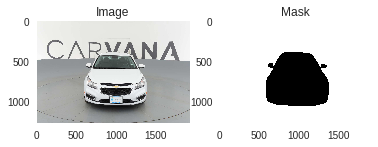

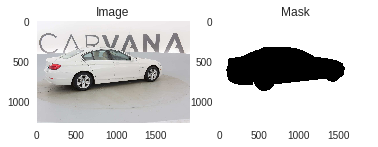

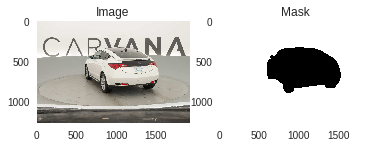

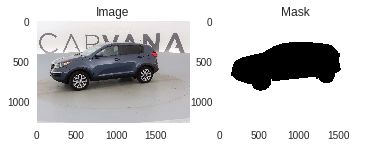

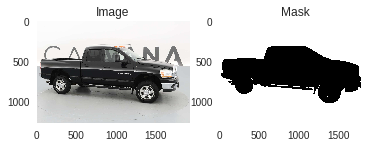

In [0]:
for i in range(5):
    image, mask = dataset[np.random.randint(0, len(dataset))]
    plot2x2Array(image, mask)

Load & resize data, data augmentation 

In [0]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# we create two instances with the same arguments
data_gen_args = dict(rescale=1./255,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     shear_range=0.2,
                     brightness_range=(0.5, 1.0),
                     validation_split=0.2
                    )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [0]:
import tensorflow as tf

def dice_coef(y_true, y_pred):
    """
    write our own dice_coeficcient metric
    """
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    isct = tf.reduce_sum(y_true * y_pred)
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [0]:
#split dataset

import os 
import glob
from sklearn.model_selection import train_test_split

filenames = train_mask['img']
train_filenames, val_test_filenames = train_test_split(filenames, test_size = 0.15)
val_filenames, test_filenames = train_test_split(val_test_filenames, test_size = 1/3)

In [0]:
car = '../content/data'
os.mkdir(car)

In [0]:
training_images = '../content/data/training_images'
training_masks = '../content/data/training_masks'
valid_images = '../content/data/valid_images'
valid_masks = '../content/data/valid_masks'
test_images = '../content/data/test_images'
test_masks = '../content/data/test_masks'

os.mkdir(training_images)
os.mkdir(training_masks)
os.mkdir(valid_images)
os.mkdir(valid_masks)
os.mkdir(test_images)
os.mkdir(test_masks)

In [0]:
#create 6 folders to contain training-valid-test data for images and masks

training_images = '../content/data/training_images/0'
training_masks = '../content/data/training_masks/0'
valid_images = '../content/data/valid_images/0'
valid_masks = '../content/data/valid_masks/0'
test_images = '../content/data/test_images/0'
test_masks = '../content/data/test_masks/0'
 
os.mkdir(training_images)
os.mkdir(training_masks)
os.mkdir(valid_images)
os.mkdir(valid_masks)
os.mkdir(test_images)
os.mkdir(test_masks)

In [0]:
#Locate training, validation and testing images into respective folder
imagedir = '../content/Images/'
maskdir = '../content/Masks/' 

for fname in train_filenames:
  os.rename(imagedir + fname, training_images + '/' + fname)

for fname in val_filenames:
  os.rename(imagedir + fname, valid_images + '/' + fname)

for fname in test_filenames:
  os.rename(imagedir + fname, test_images + '/' + fname)

In [0]:
#Locate training, validation and testing masks into respective folder

for fname in train_filenames:
  os.rename(maskdir + fname, training_masks + '/' + fname)

for fname in val_filenames:
  os.rename(maskdir + fname, valid_masks + '/' + fname)

for fname in test_filenames:
  os.rename(maskdir + fname, test_masks + '/' + fname)

In [0]:
import PIL
from PIL import Image

img_size = 256

image_args = dict(seed=seed,
    batch_size=32,
    shuffle=True,
    class_mode=None,
    target_size=(img_size, img_size),
    color_mode='rgb')

mask_args = dict(seed=seed,
    batch_size=32,
    class_mode=None,
    shuffle=True,
    target_size=(img_size, img_size), 
    color_mode='grayscale')

DIR = '../content/car/'
image = 'images'
masks = 'masks'

# combine generators into one which yields image and masks
train_generator = zip(image_datagen.flow_from_directory(**image_args, directory=DIR+'training_'+image),  
                      mask_datagen.flow_from_directory(**mask_args, directory=DIR+'training_'+masks))

validation_generator = zip(image_datagen.flow_from_directory(**image_args, directory=DIR+'valid_'+image),  
                      mask_datagen.flow_from_directory(**mask_args, directory=DIR+'valid_'+masks))

Found 4324 images belonging to 1 classes.
Found 4324 images belonging to 1 classes.
Found 509 images belonging to 1 classes.
Found 509 images belonging to 1 classes.


In [0]:
img1, mask1 = next(validation_generator)

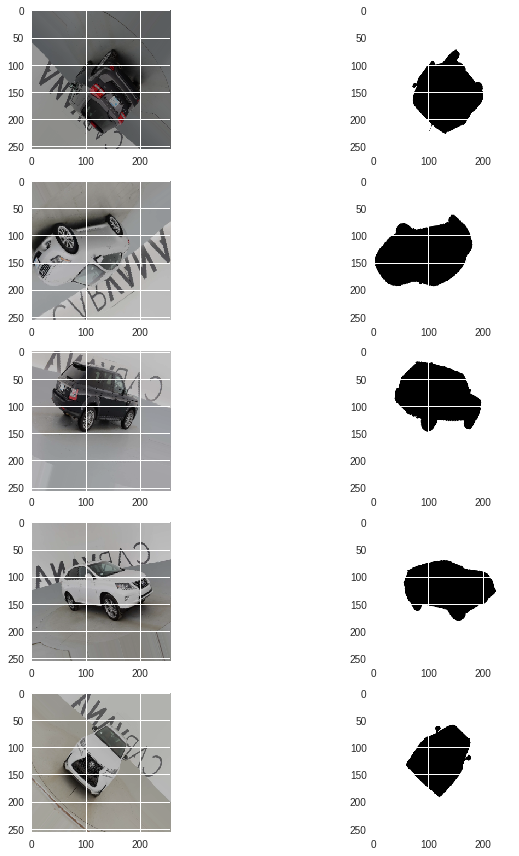

In [0]:
fig=plt.figure(figsize=(12,12))
columns = 2
rows = 5
counter = 0
c = 0
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    if counter%2 == 0:
        plt.imshow(img1[c])
    else:
        plt.imshow(mask1[c][:,:,0])
        c = c + 1
    counter = counter + 1
    

plt.tight_layout()
plt.savefig('augmented.png')
plt.show()

UNET

In [0]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import backend as K

In [0]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
img_size = 256
im_width = 256
im_height = 256
im_chan = 3

In [0]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[dice_coef]) 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 256, 256, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_173 (Conv2D)             (None, 256, 256, 8)  584         conv2d_172[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_37 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_173[0][0]                 
__________________________________________________________________________________________________
conv2d_174

In [0]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='./logs/logs_1e-4')]


In [0]:
results = model.fit_generator(train_generator, steps_per_epoch=135, epochs=15, validation_data=validation_generator, validation_steps=16, callbacks=callbacks)

Epoch 1/15


UnknownError: ignored